In [1]:
import Collobrative_Filtering as CF
import numpy as np
import pandas as pd
import redis
import json
import random
import pickle
import inspect
import os

In [2]:
redis_conn = redis.Redis(host='localhost',port=6379,db=0)

## 測試目的：使用演算法的話是否成效會比Random更好

In [3]:
model = CF.COLLOBORATIVE_FILTERING()

In [4]:
with open('tag_mapping.pickle', 'rb') as f3:
    tag_mapping = pickle.load(f3)

In [5]:
def preference_fake(data):
    number = len(data)
    random_lst = []
    for i in range(number):
        if random.randint(0,1)==1:
            random_lst.append(i)
    return random_lst

In [6]:
def preference(number):
    ran_num = random.randint(1,number)
    data = json.loads(redis_conn.get(ran_num))
    model_tags = tag_mapping.keys()
    user_tags = []
    for i in data['batchTag']:
        if i[u'TAG_ID'] in model_tags:
            user_tags.append(tag_mapping[i[u'TAG_ID']])
    return user_tags

## Model Test

In [ ]:
for j in range(1,1501):
    data = json.loads(redis_conn.get(j))
    model_tags = tag_mapping.keys()
    user_tags = []
    for i in data['batchTag']:
        if i[u'TAG_ID'] in model_tags:
            user_tags.append(tag_mapping[i[u'TAG_ID']])
    test = model.predict(user_tags,False,similar_num=5,offertag_num=15,offer_number=3)
    print test

In [ ]:
data = json.loads(redis_conn.get(1))
model_tags = tag_mapping.keys()
user_tags = []
for i in data['batchTag']:
    if i[u'TAG_ID'] in model_tags:
        user_tags.append(tag_mapping[i[u'TAG_ID']])
test = model.predict(user_tags,False,similar_num=5,offertag_num=10,offer_number=6)
test

In [ ]:
customer_tag = preference_fake(tag_mapping)
customer_reco = model.predict(customer_tag,False,similar_num=10,offertag_num=15,offer_number=3)
customer_reco

# 情境一：視每個顧客為新顧客（描述顧客標籤隨機給予）

### 顧客初始不喜歡推薦，且推薦各自獨立，Swich推薦的比例

In [ ]:
with open('offerlabel_mapping.pickle', 'rb') as f2:
    offerlabel_mapping = pickle.load(f2)
offer_tags = pd.read_csv('OFFERTAG_MAPPING.csv')

In [ ]:
def input_data_case1(number, tag_mapping):
    customer = np.zeros(number).tolist()
    for i in range(number):
        cust_tag = preference(1500)
        #tag = np.zeros(len(tag_mapping))
        #tag[[cust_tag]] = 1
        customer[i] = cust_tag
    return customer

In [ ]:
def simulation_case1(cust_tag, times, offer_tags, offerlabel_mapping, tag_mapping):
    response = np.zeros([len(cust_tag), times, 2]).tolist()
    for i in range(times):
        for j in range(len(cust_tag)):
            customer_reco = model.predict(cust_tag[j], False, similar_num=10, offertag_num=15, offer_number=3)
            label = offer_tags[offer_tags.OFFER_ID.isin(customer_reco)].LABEL_ID.unique()

            # 令3個被推薦的點擊機率均為0.1，且互相獨立
            if random.random()>=(0.9)**3:
                reco = customer_reco[random.randint(0,2)]
                label = offer_tags[offer_tags.OFFER_ID.isin([reco])].LABEL_ID.unique()
                offerlabel_map = {}
                offerlabel = np.zeros(len(offerlabel_mapping))
                for r in offerlabel_mapping.keys():
                    offerlabel_map[offerlabel_mapping[r]]=r
                for k in label:
                    offerlabel[offerlabel_map[k]] = 1
                rating_table = model.fit(cust_tag[j],offerlabel,True)
                response[j][i][0] = ','.join(customer_reco)
                response[j][i][1] = reco
                print 'Finish ' + str(j+1) + ' customer ' + str(i+1) + ' times!!' 

            else:

                response[j][i][0] = ','.join(customer_reco)
                print 'Finish ' + str(j+1) + ' customer ' + str(i+1) + ' times!!'  
    return response

In [ ]:
sim_data = input_data(100, tag_mapping)

In [ ]:
result = simulation_case1(sim_data,10,offer_tags,offerlabel_mapping,tag_mapping)

# 情境二：視每個顧客為新顧客（描述顧客標籤固定）

### 顧客初始有喜好分配，推薦內容各自獨立，其在模型運算後最後跑到他所喜好的產品機率

顧客 ID : 9, 10, 38, 48, 57, 71, 72, 78, 86, 90

In [7]:
# Load Customer's Truely Preference
with open('Preference.pickle', 'rb') as f:
    Preference_Dist = pickle.load(f)
with open('IndexMapOffer.pickle', 'rb') as f1:
    IndexMapOffer = pickle.load(f1)
with open('offerlabel_mapping.pickle', 'rb') as f2:
    offerlabel_mapping = pickle.load(f2)
offer_tags = pd.read_csv('OFFERTAG_MAPPING.csv')
with open('RealDist.pickle', 'rb') as f3:
    ClickDist = pickle.load(f3)
with open('offer_maptb.pickle', 'rb') as f4:
    Offer_Maptb = pickle.load(f4)

In [8]:
# 將顧客資訊萃取出來
cust_id = [9, 10, 38, 48, 57, 71, 72, 78, 86, 90]
test_data = []
for j in cust_id:
    data = json.loads(redis_conn.get(j))
    model_tags = tag_mapping.keys()
    user_tags = []
    for i in data['batchTag']:
        if i[u'TAG_ID'] in model_tags:
            user_tags.append(tag_mapping[i[u'TAG_ID']])
    test_data.append(user_tags)

In [9]:
# 現實生活上的點擊率
answer = np.zeros(len(Preference_Dist)).tolist()
for data in range(len(Preference_Dist)):
    answer[data] = 1 - ((1 - sorted(Preference_Dist[data],reverse=True)[0])*
                    (1 - sorted(Preference_Dist[data],reverse=True)[1])*
                    (1 - sorted(Preference_Dist[data],reverse=True)[2]))

In [10]:
def simulation_case2(cust_tag, times, offer_tags, offerlabel_mapping, tag_mapping, Preference_Dist, IndexMapOffer, answer):
    response = np.zeros([len(cust_tag), times, 4]).tolist()
    recommand_items = np.ones(len(cust_tag))
    reco_distribution = np.zeros([len(cust_tag),len(IndexMapOffer)])
    for i in range(times):
        for j in range(len(cust_tag)):
            if recommand_items[j] > 13:
                recommand_items[j] = 1
            customer_reco = model.predict(cust_tag[j], False, similar_num=10, offertag_num=15, offer_number= int(3*recommand_items[j]))[-3:]
            Preference_lst = []
            NonClick_Rate_tot = 1
            recommand_items[j] += 1 
            for data in customer_reco:
                Preference_lst.append(Preference_Dist[j][IndexMapOffer[data]])
                NonClick_Rate_tot *= 1 - Preference_Dist[j][IndexMapOffer[data]]
                reco_distribution[j][IndexMapOffer[data]] += 1
            Preference_lst = np.array(Preference_lst)/np.array(Preference_lst).sum()    
            Click_Rate_tot = 1- NonClick_Rate_tot
            print Click_Rate_tot
                            
            # 使用Preference的資訊
            if random.random()>=NonClick_Rate_tot:
                #Choose item
                choose = random.random()
                for item_num in range(len(Preference_lst)):
                    if  Preference_lst[:item_num].sum()<=choose<=Preference_lst[:item_num+1].sum():
                        reco = customer_reco[item_num]
                        reco_labels = offer_tags[offer_tags.OFFER_ID.isin([reco])].LABEL_ID.unique()
                        offerlabel_map = {}
                        offerlabel = np.zeros(len(offerlabel_mapping))

                        for key in offerlabel_mapping.keys():
                            offerlabel_map[offerlabel_mapping[key]]=key
                        for label in reco_labels:
                            offerlabel[offerlabel_map[label]] = 1
                        rating_table = model.fit(cust_tag[j],offerlabel,True)                    
                        response[j][i][1] = reco
                        recommand_items[j] = 1
                        print 'The ' + str(j+1) + ' customer clicked ' + str(item_num+1) + ' recommand item!!'
                        break
                                                                 
            response[j][i][0] = ','.join(customer_reco)
            response[j][i][2] = Click_Rate_tot
            response[j][i][3] = (Click_Rate_tot - answer[j])**2
            print 'Finish ' + str(j+1) + ' customer ' + str(i+1) + ' times!!'  
                    
    return (response , reco_distribution)

In [11]:
result_case2 = simulation_case2(test_data,200,offer_tags,offerlabel_mapping,tag_mapping,Preference_Dist, IndexMapOffer,answer)

0.014925125
Finish 1 customer 1 times!!
0.014925125
Finish 2 customer 1 times!!
0.20798
Finish 3 customer 1 times!!
0.20798
Finish 4 customer 1 times!!
0.20798
Finish 5 customer 1 times!!
0.20798
Finish 6 customer 1 times!!
0.801995
Finish 7 customer 1 times!!
0.20798
Finish 8 customer 1 times!!
0.014925125
Finish 9 customer 1 times!!
0.014925125
Finish 10 customer 1 times!!
0.014925125
Finish 1 customer 2 times!!
0.975249375
The 2 customer clicked 3 recommand item!!
Finish 2 customer 2 times!!
0.014925125
Finish 3 customer 2 times!!
0.014925125
Finish 4 customer 2 times!!
0.014925125
Finish 5 customer 2 times!!
0.014925125
Finish 6 customer 2 times!!
0.014925125
Finish 7 customer 2 times!!
0.014925125
Finish 8 customer 2 times!!
0.014925125
Finish 9 customer 2 times!!
0.014925125
Finish 10 customer 2 times!!
0.20798
The 1 customer clicked 3 recommand item!!
Finish 1 customer 3 times!!
0.014925125
Finish 2 customer 3 times!!
0.014925125
Finish 3 customer 3 times!!
0.014925125
Finish 4 

0.014925125
Finish 10 customer 19 times!!
0.20798
The 1 customer clicked 1 recommand item!!
Finish 1 customer 20 times!!
0.014925125
Finish 2 customer 20 times!!
0.014925125
Finish 3 customer 20 times!!
0.014925125
Finish 4 customer 20 times!!
0.975249375
The 5 customer clicked 2 recommand item!!
Finish 5 customer 20 times!!
0.014925125
Finish 6 customer 20 times!!
0.014925125
Finish 7 customer 20 times!!
0.014925125
Finish 8 customer 20 times!!
0.014925125
Finish 9 customer 20 times!!
0.014925125
Finish 10 customer 20 times!!
0.014925125
Finish 1 customer 21 times!!
0.014925125
Finish 2 customer 21 times!!
0.20798
The 3 customer clicked 2 recommand item!!
Finish 3 customer 21 times!!
0.014925125
Finish 4 customer 21 times!!
0.20798
The 5 customer clicked 1 recommand item!!
Finish 5 customer 21 times!!
0.014925125
Finish 6 customer 21 times!!
0.014925125
Finish 7 customer 21 times!!
0.014925125
Finish 8 customer 21 times!!
0.014925125
Finish 9 customer 21 times!!
0.014925125
Finish 10 

The 2 customer clicked 1 recommand item!!
Finish 2 customer 36 times!!
0.20798
The 3 customer clicked 2 recommand item!!
Finish 3 customer 36 times!!
0.014925125
Finish 4 customer 36 times!!
0.975249375
The 5 customer clicked 3 recommand item!!
Finish 5 customer 36 times!!
0.014925125
Finish 6 customer 36 times!!
0.014925125
Finish 7 customer 36 times!!
0.014925125
Finish 8 customer 36 times!!
0.014925125
Finish 9 customer 36 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 36 times!!
0.014925125
Finish 1 customer 37 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 37 times!!
0.20798
Finish 3 customer 37 times!!
0.014925125
Finish 4 customer 37 times!!
0.20798
Finish 5 customer 37 times!!
0.014925125
Finish 6 customer 37 times!!
0.014925125
Finish 7 customer 37 times!!
0.014925125
Finish 8 customer 37 times!!
0.014925125
Finish 9 customer 37 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 

The 10 customer clicked 1 recommand item!!
Finish 10 customer 52 times!!
0.014925125
Finish 1 customer 53 times!!
0.014925125
Finish 2 customer 53 times!!
0.014925125
Finish 3 customer 53 times!!
0.014925125
Finish 4 customer 53 times!!
0.014925125
Finish 5 customer 53 times!!
0.014925125
Finish 6 customer 53 times!!
0.801995
The 7 customer clicked 1 recommand item!!
Finish 7 customer 53 times!!
0.20798
Finish 8 customer 53 times!!
0.014925125
Finish 9 customer 53 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 53 times!!
0.014925125
Finish 1 customer 54 times!!
0.014925125
Finish 2 customer 54 times!!
0.20798
Finish 3 customer 54 times!!
0.014925125
Finish 4 customer 54 times!!
0.975249375
The 5 customer clicked 3 recommand item!!
Finish 5 customer 54 times!!
0.014925125
Finish 6 customer 54 times!!
0.801995
The 7 customer clicked 1 recommand item!!
Finish 7 customer 54 times!!
0.014925125
Finish 8 customer 54 times!!
0.014925125
Finish 9 customer 54 

0.20798
Finish 5 customer 69 times!!
0.014925125
Finish 6 customer 69 times!!
0.014925125
Finish 7 customer 69 times!!
0.034725625
Finish 8 customer 69 times!!
0.014925125
Finish 9 customer 69 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 69 times!!
0.014925125
Finish 1 customer 70 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 70 times!!
0.014925125
Finish 3 customer 70 times!!
0.014925125
Finish 4 customer 70 times!!
0.014925125
Finish 5 customer 70 times!!
0.014925125
Finish 6 customer 70 times!!
0.014925125
Finish 7 customer 70 times!!
0.014925125
Finish 8 customer 70 times!!
0.014925125
Finish 9 customer 70 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 70 times!!
0.20798
Finish 1 customer 71 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 71 times!!
0.014925125
Finish 3 customer 71 times!!
0.014925125
Finish 4 customer 71 times!!
0.975249375
The 

The 9 customer clicked 1 recommand item!!
Finish 9 customer 87 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 87 times!!
0.014925125
Finish 1 customer 88 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 88 times!!
0.014925125
Finish 3 customer 88 times!!
0.014925125
Finish 4 customer 88 times!!
0.014925125
Finish 5 customer 88 times!!
0.014925125
Finish 6 customer 88 times!!
0.014925125
Finish 7 customer 88 times!!
0.014925125
Finish 8 customer 88 times!!
0.801995
Finish 9 customer 88 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 88 times!!
0.014925125
Finish 1 customer 89 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 89 times!!
0.014925125
Finish 3 customer 89 times!!
0.014925125
Finish 4 customer 89 times!!
0.975249375
The 5 customer clicked 3 recommand item!!
Finish 5 customer 89 times!!
0.014925125
The 6 customer clicked 2 recommand item!!
Finish 6

The 10 customer clicked 1 recommand item!!
Finish 10 customer 104 times!!
0.014925125
Finish 1 customer 105 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 105 times!!
0.014925125
Finish 3 customer 105 times!!
0.014925125
Finish 4 customer 105 times!!
0.20798
Finish 5 customer 105 times!!
0.014925125
Finish 6 customer 105 times!!
0.801995
The 7 customer clicked 1 recommand item!!
Finish 7 customer 105 times!!
0.20798
Finish 8 customer 105 times!!
0.014925125
Finish 9 customer 105 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 105 times!!
0.014925125
Finish 1 customer 106 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 106 times!!
0.20798
Finish 3 customer 106 times!!
0.014925125
Finish 4 customer 106 times!!
0.014925125
Finish 5 customer 106 times!!
0.014925125
Finish 6 customer 106 times!!
0.801995
The 7 customer clicked 1 recommand item!!
Finish 7 customer 106 times!!
0.014925125
Finish

0.014925125
Finish 4 customer 122 times!!
0.014925125
Finish 5 customer 122 times!!
0.014925125
Finish 6 customer 122 times!!
0.014925125
Finish 7 customer 122 times!!
0.014925125
Finish 8 customer 122 times!!
0.014925125
Finish 9 customer 122 times!!
0.014925125
Finish 10 customer 122 times!!
0.014925125
Finish 1 customer 123 times!!
0.014925125
Finish 2 customer 123 times!!
0.014925125
Finish 3 customer 123 times!!
0.014925125
Finish 4 customer 123 times!!
0.975249375
The 5 customer clicked 3 recommand item!!
Finish 5 customer 123 times!!
0.014925125
Finish 6 customer 123 times!!
0.014925125
Finish 7 customer 123 times!!
0.014925125
Finish 8 customer 123 times!!
0.014925125
Finish 9 customer 123 times!!
0.014925125
Finish 10 customer 123 times!!
0.014925125
Finish 1 customer 124 times!!
0.014925125
Finish 2 customer 124 times!!
0.014925125
Finish 3 customer 124 times!!
0.014925125
Finish 4 customer 124 times!!
0.20798
Finish 5 customer 124 times!!
0.014925125
Finish 6 customer 124 ti

The 2 customer clicked 1 recommand item!!
Finish 2 customer 139 times!!
0.014925125
Finish 3 customer 139 times!!
0.014925125
Finish 4 customer 139 times!!
0.975249375
The 5 customer clicked 3 recommand item!!
Finish 5 customer 139 times!!
0.20798
The 6 customer clicked 3 recommand item!!
Finish 6 customer 139 times!!
0.014925125
Finish 7 customer 139 times!!
0.014925125
Finish 8 customer 139 times!!
0.801995
The 9 customer clicked 1 recommand item!!
Finish 9 customer 139 times!!
0.014925125
Finish 10 customer 139 times!!
0.20798
Finish 1 customer 140 times!!
0.975249375
Finish 2 customer 140 times!!
0.014925125
Finish 3 customer 140 times!!
0.014925125
Finish 4 customer 140 times!!
0.20798
Finish 5 customer 140 times!!
0.20798
Finish 6 customer 140 times!!
0.014925125
Finish 7 customer 140 times!!
0.014925125
Finish 8 customer 140 times!!
0.801995
Finish 9 customer 140 times!!
0.014925125
Finish 10 customer 140 times!!
0.014925125
Finish 1 customer 141 times!!
0.014925125
Finish 2 cus

0.20798
Finish 5 customer 156 times!!
0.014925125
Finish 6 customer 156 times!!
0.801995
The 7 customer clicked 1 recommand item!!
Finish 7 customer 156 times!!
0.014925125
Finish 8 customer 156 times!!
0.014925125
Finish 9 customer 156 times!!
0.014925125
Finish 10 customer 156 times!!
0.014925125
Finish 1 customer 157 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 157 times!!
0.20798
Finish 3 customer 157 times!!
0.014925125
Finish 4 customer 157 times!!
0.014925125
Finish 5 customer 157 times!!
0.014925125
Finish 6 customer 157 times!!
0.801995
The 7 customer clicked 1 recommand item!!
Finish 7 customer 157 times!!
0.014925125
Finish 8 customer 157 times!!
0.014925125
Finish 9 customer 157 times!!
0.014925125
Finish 10 customer 157 times!!
0.014925125
Finish 1 customer 158 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 158 times!!
0.20798
The 3 customer clicked 1 recommand item!!
Finish 3 customer 158 times!!
0.20798


0.20798
The 3 customer clicked 2 recommand item!!
Finish 3 customer 173 times!!
0.014925125
Finish 4 customer 173 times!!
0.975249375
The 5 customer clicked 3 recommand item!!
Finish 5 customer 173 times!!
0.014925125
Finish 6 customer 173 times!!
0.014925125
Finish 7 customer 173 times!!
0.014925125
Finish 8 customer 173 times!!
0.014925125
Finish 9 customer 173 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 173 times!!
0.014925125
Finish 1 customer 174 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 174 times!!
0.20798
Finish 3 customer 174 times!!
0.014925125
The 4 customer clicked 1 recommand item!!
Finish 4 customer 174 times!!
0.20798
Finish 5 customer 174 times!!
0.20798
Finish 6 customer 174 times!!
0.014925125
Finish 7 customer 174 times!!
0.014925125
Finish 8 customer 174 times!!
0.014925125
Finish 9 customer 174 times!!
0.975249375
Finish 10 customer 174 times!!
0.014925125
Finish 1 customer 175 times!!
0.975

0.20798
Finish 6 customer 188 times!!
0.801995
The 7 customer clicked 1 recommand item!!
Finish 7 customer 188 times!!
0.014925125
Finish 8 customer 188 times!!
0.014925125
Finish 9 customer 188 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 188 times!!
0.014925125
Finish 1 customer 189 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 189 times!!
0.014925125
Finish 3 customer 189 times!!
0.20798
The 4 customer clicked 1 recommand item!!
Finish 4 customer 189 times!!
0.975249375
Finish 5 customer 189 times!!
0.014925125
Finish 6 customer 189 times!!
0.801995
The 7 customer clicked 1 recommand item!!
Finish 7 customer 189 times!!
0.034725625
Finish 8 customer 189 times!!
0.014925125
Finish 9 customer 189 times!!
0.975249375
The 10 customer clicked 1 recommand item!!
Finish 10 customer 189 times!!
0.014925125
Finish 1 customer 190 times!!
0.975249375
The 2 customer clicked 1 recommand item!!
Finish 2 customer 190 times!!
0.

# 結果一：與假設的Preference最喜歡的推薦組合距離

In [12]:
final = []
for i in range(len(result_case2[0])):
    final.append(result_case2[0][i][-1])
final

[['OFF0037,OFF0039,OFF0041', 0.0, 0.014925124999999984, 0.037270184761265611],
 ['OFF0004,OFF0005,OFF0008', 'OFF0004', 0.97524937499999997, 0.0],
 ['OFF0001,OFF0002,OFF0006', 0.0, 0.014925124999999984, 0.22379983735626552],
 ['OFF0011,OFF0021,OFF0022', 0.0, 0.014925124999999984, 0.037270184761265611],
 ['OFF0007,OFF0023,OFF0024', 0.0, 0.20797999999999994, 0.59616929439999999],
 ['OFF0039,OFF0040,OFF0041', 0.0, 0.014925124999999984, 0.037270184761265611],
 ['OFF0023,OFF0024,OFF0025',
  'OFF0024',
  0.014925124999999984,
  0.61947898813251567],
 ['OFF0001,OFF0025,OFF0010', 0.0, 0.014925124999999984, 0.043670498381265625],
 ['OFF0019,OFF0004,OFF0005', 0.0, 0.80199500000000001, 0.0],
 ['OFF0044,OFF0008,OFF0004', 'OFF0044', 0.97524937499999997, 0.0]]

# 結果二：與實際上的實際該名顧客點擊分布圖做比較（藍色：預測，紅色：實際）

In [13]:
import matplotlib.pyplot as plt

In [14]:
# 推薦商品分佈
recommand_distribution = np.zeros(result_case2[1].shape)
for i in range(len(result_case2[1])):
    recommand_distribution[i] = result_case2[1][i]/result_case2[1][i].sum()
# 實際點擊分布
real_distribution = np.zeros(ClickDist.shape)
for j in range(len(ClickDist)):
    real_distribution[j] = ClickDist[j]/ClickDist[j].sum()

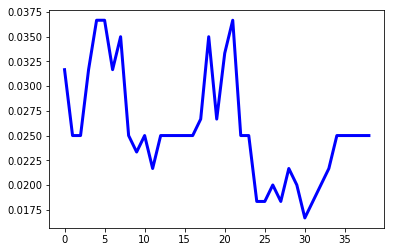

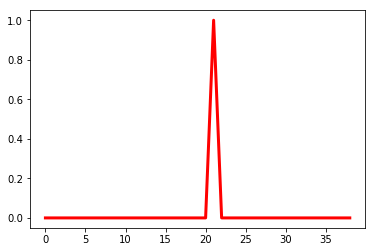

In [15]:
# Customer 1
plt.plot(range(len(recommand_distribution[0])), recommand_distribution[0], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[0])), real_distribution[0], color = "red", linewidth = 3, linestyle = "-")
plt.show()

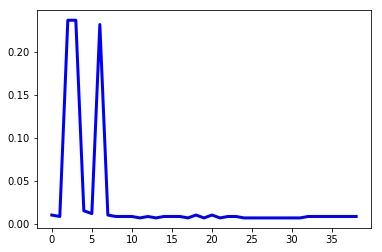

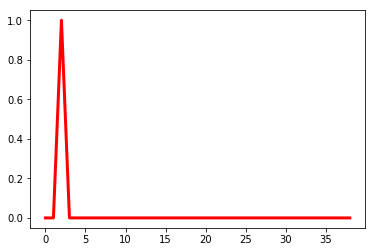

In [16]:
# Customer 2
plt.plot(range(len(recommand_distribution[1])), recommand_distribution[1], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[1])), real_distribution[1], color = "red", linewidth = 3, linestyle = "-")
plt.show()

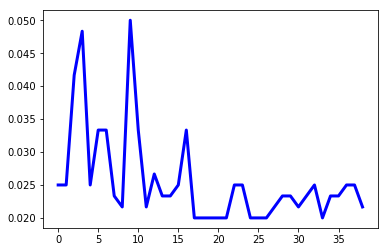

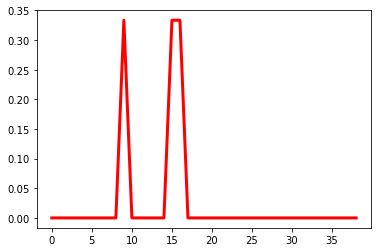

In [17]:
# Customer 3
plt.plot(range(len(recommand_distribution[2])), recommand_distribution[2], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[2])), real_distribution[2], color = "red", linewidth = 3, linestyle = "-")
plt.show()

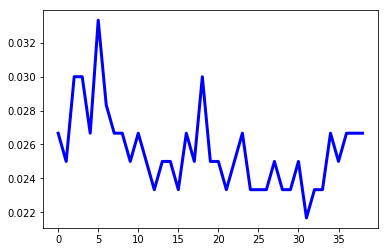

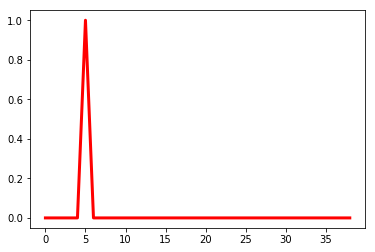

In [18]:
# Customer 4
plt.plot(range(len(recommand_distribution[3])), recommand_distribution[3], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[3])), real_distribution[3], color = "red", linewidth = 3, linestyle = "-")
plt.show()

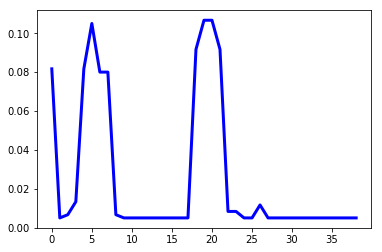

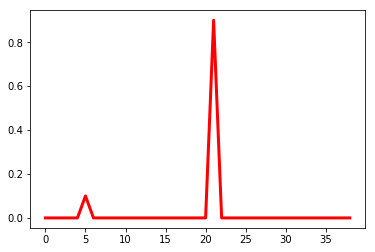

In [19]:
# Customer 5
plt.plot(range(len(recommand_distribution[4])), recommand_distribution[4], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[4])), real_distribution[4], color = "red", linewidth = 3, linestyle = "-")
plt.show()

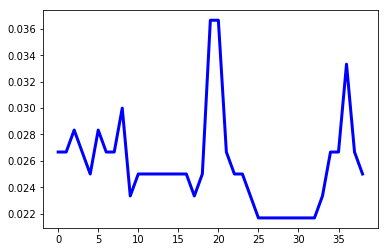

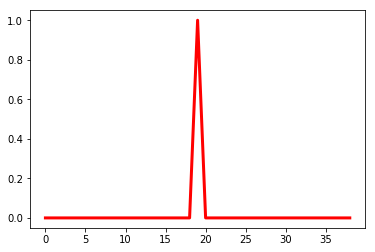

In [20]:
# Customer 6
plt.plot(range(len(recommand_distribution[5])), recommand_distribution[5], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[5])), real_distribution[5], color = "red", linewidth = 3, linestyle = "-")
plt.show()

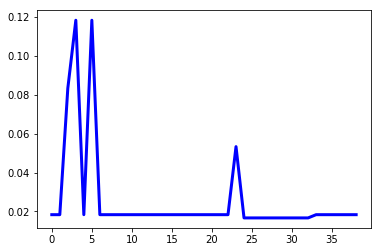

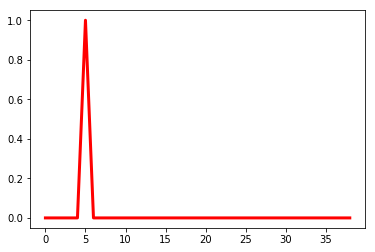

In [21]:
# Customer 7
plt.plot(range(len(recommand_distribution[6])), recommand_distribution[6], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[6])), real_distribution[6], color = "red", linewidth = 3, linestyle = "-")
plt.show()

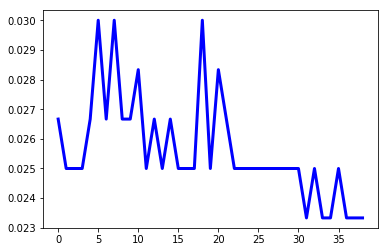

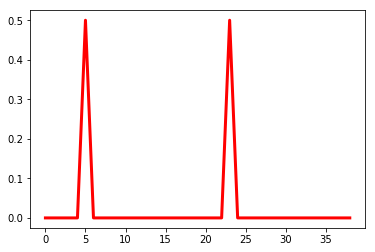

In [22]:
# Customer 8
plt.plot(range(len(recommand_distribution[7])), recommand_distribution[7], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[7])), real_distribution[7], color = "red", linewidth = 3, linestyle = "-")
plt.show()

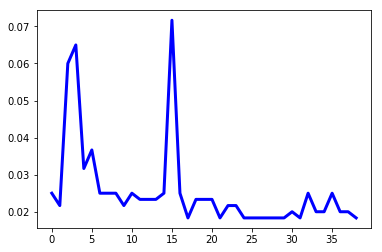

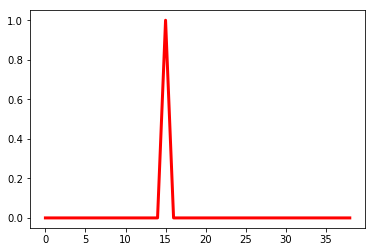

In [23]:
# Customer 9
plt.plot(range(len(recommand_distribution[8])), recommand_distribution[8], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[8])), real_distribution[8], color = "red", linewidth = 3, linestyle = "-")
plt.show()

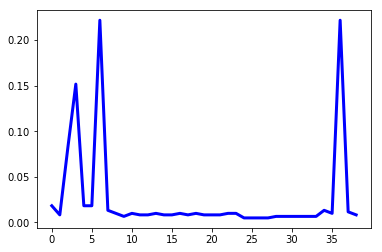

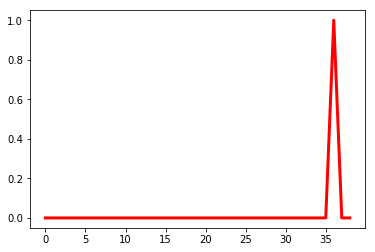

In [24]:
# Customer 10
plt.plot(range(len(recommand_distribution[9])), recommand_distribution[9], color = "blue", linewidth = 3, linestyle = "-")
plt.show()

plt.plot(range(len(real_distribution[9])), real_distribution[9], color = "red", linewidth = 3, linestyle = "-")
plt.show()

# 情境三：與隨機結果進行比較

In [25]:
def simulation_case3(cust_tag, times, offer_tags, offerlabel_mapping, tag_mapping, Preference_Dist, IndexMapOffer, answer):
    response = np.zeros([len(cust_tag), times, 4]).tolist()
    recommand_items = np.ones(len(cust_tag))
    for i in range(times):
        for j in range(len(cust_tag)):
            if recommand_items[j] > 13:
                recommand_items[j] = 1
            random_recommandation = np.random.randint(38,size=3)
            customer_reco = model.predict(cust_tag[j], False, similar_num=10, offertag_num=15, offer_number= int(3*recommand_items[j]))[-3:]
            Preference_lst = []
            Preference_lst_ran = []
            NonClick_Rate_tot = 1
            NonClick_Rate_tot_ran = 1
            recommand_items[j] += 1 
            
            for data in customer_reco:
                Preference_lst.append(Preference_Dist[j][IndexMapOffer[data]])
                NonClick_Rate_tot *= 1 - Preference_Dist[j][IndexMapOffer[data]]
                
            for random_reco_ind in random_recommandation:
                Preference_lst_ran.append(Preference_Dist[j][random_reco_ind])
                NonClick_Rate_tot_ran *= 1 - Preference_Dist[j][random_reco_ind]
                
            Preference_lst = np.array(Preference_lst)/np.array(Preference_lst).sum()
            Preference_lst_ran = np.array(Preference_lst_ran)/np.array(Preference_lst_ran).sum()
            response[j][i][1] = response[j][i-1][1]
            response[j][i][3] = response[j][i-1][3]
            # Model Recommandation使用Preference的資訊
            if random.random()>=NonClick_Rate_tot:
                #Choose item
                choose = random.random()
                for item_num in range(len(Preference_lst)):
                    if  Preference_lst[:item_num].sum()<=choose<=Preference_lst[:item_num+1].sum():
                        reco = customer_reco[item_num]
                        reco_labels = offer_tags[offer_tags.OFFER_ID.isin([reco])].LABEL_ID.unique()
                        offerlabel_map = {}
                        offerlabel = np.zeros(len(offerlabel_mapping))

                        for key in offerlabel_mapping.keys():
                            offerlabel_map[offerlabel_mapping[key]]=key
                        for label in reco_labels:
                            offerlabel[offerlabel_map[label]] = 1
                        rating_table = model.fit(cust_tag[j],offerlabel,True)
                        response[j][i][0] = reco
                        response[j][i][1] = (response[j][i-1][1] + 1)
                        recommand_items[j] = 1
                        print  str(j+1) + ' customer clicked ' + str(item_num+1) + ' recommand item!!'
                        print response[j][i][1]
                        break

            # Random Recommandation使用Preference的資訊
            if random.random()>=NonClick_Rate_tot_ran:
                #Choose item
                choose = random.random()
                for item in range(len(Preference_lst)):
                    if  Preference_lst[:item].sum()<=choose<=Preference_lst[:item+1].sum():
                        reco_ran = customer_reco[item]
                        response[j][i][2] = reco_ran
                        response[j][i][3] = (response[j][i-1][3] + 1)
                        print str(j+1) + ' customer clicked ' + str(item_num+1) + ' random recommand item!!'
                        break
            
            print 'Finish ' + str(j+1) + ' customer ' + str(i+1) + ' times!!'  
    
    return response

In [26]:
result = simulation_case3(test_data,200,offer_tags,offerlabel_mapping,tag_mapping,Preference_Dist, IndexMapOffer,answer)

Finish 1 customer 1 times!!
Finish 2 customer 1 times!!
3 customer clicked 3 recommand item!!
1.0
Finish 3 customer 1 times!!
Finish 4 customer 1 times!!
Finish 5 customer 1 times!!
Finish 6 customer 1 times!!
7 customer clicked 1 recommand item!!
1.0
Finish 7 customer 1 times!!
Finish 8 customer 1 times!!
Finish 9 customer 1 times!!
Finish 10 customer 1 times!!
Finish 1 customer 2 times!!
2 customer clicked 3 recommand item!!
1.0
Finish 2 customer 2 times!!
Finish 3 customer 2 times!!
Finish 4 customer 2 times!!
Finish 5 customer 2 times!!
Finish 6 customer 2 times!!
7 customer clicked 1 recommand item!!
2.0
Finish 7 customer 2 times!!
Finish 8 customer 2 times!!
Finish 9 customer 2 times!!
Finish 10 customer 2 times!!
Finish 1 customer 3 times!!
Finish 2 customer 3 times!!
3 customer clicked 1 random recommand item!!
Finish 3 customer 3 times!!
Finish 4 customer 3 times!!
Finish 5 customer 3 times!!
Finish 6 customer 3 times!!
Finish 7 customer 3 times!!
Finish 8 customer 3 times!!
F

2 customer clicked 1 recommand item!!
7.0
Finish 2 customer 25 times!!
Finish 3 customer 25 times!!
Finish 4 customer 25 times!!
5 customer clicked 1 random recommand item!!
Finish 5 customer 25 times!!
Finish 6 customer 25 times!!
Finish 7 customer 25 times!!
Finish 8 customer 25 times!!
Finish 9 customer 25 times!!
10 customer clicked 1 recommand item!!
7.0
Finish 10 customer 25 times!!
Finish 1 customer 26 times!!
2 customer clicked 1 recommand item!!
8.0
Finish 2 customer 26 times!!
3 customer clicked 1 recommand item!!
3.0
Finish 3 customer 26 times!!
Finish 4 customer 26 times!!
Finish 5 customer 26 times!!
6 customer clicked 2 recommand item!!
1.0
Finish 6 customer 26 times!!
Finish 7 customer 26 times!!
Finish 8 customer 26 times!!
Finish 9 customer 26 times!!
10 customer clicked 1 recommand item!!
8.0
Finish 10 customer 26 times!!
Finish 1 customer 27 times!!
2 customer clicked 1 recommand item!!
9.0
Finish 2 customer 27 times!!
Finish 3 customer 27 times!!
Finish 4 customer 2

Finish 3 customer 45 times!!
Finish 4 customer 45 times!!
5 customer clicked 3 recommand item!!
17.0
5 customer clicked 3 random recommand item!!
Finish 5 customer 45 times!!
Finish 6 customer 45 times!!
Finish 7 customer 45 times!!
Finish 8 customer 45 times!!
9 customer clicked 1 recommand item!!
8.0
9 customer clicked 1 random recommand item!!
Finish 9 customer 45 times!!
Finish 10 customer 45 times!!
Finish 1 customer 46 times!!
2 customer clicked 1 recommand item!!
28.0
Finish 2 customer 46 times!!
3 customer clicked 1 random recommand item!!
Finish 3 customer 46 times!!
4 customer clicked 1 recommand item!!
2.0
Finish 4 customer 46 times!!
Finish 5 customer 46 times!!
Finish 6 customer 46 times!!
Finish 7 customer 46 times!!
Finish 8 customer 46 times!!
9 customer clicked 1 recommand item!!
9.0
Finish 9 customer 46 times!!
Finish 10 customer 46 times!!
Finish 1 customer 47 times!!
2 customer clicked 1 recommand item!!
29.0
Finish 2 customer 47 times!!
Finish 3 customer 47 times!!

10 customer clicked 1 recommand item!!
37.0
Finish 10 customer 64 times!!
Finish 1 customer 65 times!!
2 customer clicked 1 recommand item!!
47.0
2 customer clicked 1 random recommand item!!
Finish 2 customer 65 times!!
Finish 3 customer 65 times!!
Finish 4 customer 65 times!!
Finish 5 customer 65 times!!
Finish 6 customer 65 times!!
7 customer clicked 1 recommand item!!
21.0
Finish 7 customer 65 times!!
8 customer clicked 1 random recommand item!!
Finish 8 customer 65 times!!
Finish 9 customer 65 times!!
10 customer clicked 1 recommand item!!
38.0
Finish 10 customer 65 times!!
Finish 1 customer 66 times!!
2 customer clicked 1 recommand item!!
48.0
Finish 2 customer 66 times!!
Finish 3 customer 66 times!!
Finish 4 customer 66 times!!
Finish 5 customer 66 times!!
Finish 6 customer 66 times!!
7 customer clicked 1 recommand item!!
22.0
Finish 7 customer 66 times!!
Finish 8 customer 66 times!!
Finish 9 customer 66 times!!
10 customer clicked 1 recommand item!!
39.0
Finish 10 customer 66 ti

5 customer clicked 2 recommand item!!
26.0
Finish 5 customer 85 times!!
Finish 6 customer 85 times!!
Finish 7 customer 85 times!!
Finish 8 customer 85 times!!
Finish 9 customer 85 times!!
10 customer clicked 1 recommand item!!
58.0
Finish 10 customer 85 times!!
Finish 1 customer 86 times!!
2 customer clicked 1 recommand item!!
68.0
Finish 2 customer 86 times!!
Finish 3 customer 86 times!!
Finish 4 customer 86 times!!
Finish 5 customer 86 times!!
Finish 6 customer 86 times!!
Finish 7 customer 86 times!!
Finish 8 customer 86 times!!
Finish 9 customer 86 times!!
10 customer clicked 1 recommand item!!
59.0
Finish 10 customer 86 times!!
Finish 1 customer 87 times!!
2 customer clicked 1 recommand item!!
69.0
Finish 2 customer 87 times!!
Finish 3 customer 87 times!!
Finish 4 customer 87 times!!
Finish 5 customer 87 times!!
Finish 6 customer 87 times!!
Finish 7 customer 87 times!!
Finish 8 customer 87 times!!
9 customer clicked 1 random recommand item!!
Finish 9 customer 87 times!!
10 customer

2 customer clicked 1 recommand item!!
87.0
Finish 2 customer 105 times!!
Finish 3 customer 105 times!!
Finish 4 customer 105 times!!
Finish 5 customer 105 times!!
Finish 6 customer 105 times!!
Finish 7 customer 105 times!!
Finish 8 customer 105 times!!
Finish 9 customer 105 times!!
10 customer clicked 1 recommand item!!
65.0
Finish 10 customer 105 times!!
Finish 1 customer 106 times!!
2 customer clicked 1 recommand item!!
88.0
Finish 2 customer 106 times!!
Finish 3 customer 106 times!!
4 customer clicked 1 random recommand item!!
Finish 4 customer 106 times!!
5 customer clicked 2 recommand item!!
33.0
Finish 5 customer 106 times!!
Finish 6 customer 106 times!!
Finish 7 customer 106 times!!
Finish 8 customer 106 times!!
Finish 9 customer 106 times!!
10 customer clicked 1 recommand item!!
66.0
Finish 10 customer 106 times!!
Finish 1 customer 107 times!!
2 customer clicked 1 recommand item!!
89.0
Finish 2 customer 107 times!!
Finish 3 customer 107 times!!
Finish 4 customer 107 times!!
Fin

2 customer clicked 1 recommand item!!
107.0
Finish 2 customer 125 times!!
Finish 3 customer 125 times!!
Finish 4 customer 125 times!!
5 customer clicked 2 recommand item!!
40.0
Finish 5 customer 125 times!!
Finish 6 customer 125 times!!
7 customer clicked 1 recommand item!!
29.0
Finish 7 customer 125 times!!
Finish 8 customer 125 times!!
Finish 9 customer 125 times!!
Finish 10 customer 125 times!!
Finish 1 customer 126 times!!
2 customer clicked 1 recommand item!!
108.0
Finish 2 customer 126 times!!
Finish 3 customer 126 times!!
Finish 4 customer 126 times!!
Finish 5 customer 126 times!!
Finish 6 customer 126 times!!
7 customer clicked 1 recommand item!!
30.0
Finish 7 customer 126 times!!
8 customer clicked 1 recommand item!!
4.0
Finish 8 customer 126 times!!
Finish 9 customer 126 times!!
Finish 10 customer 126 times!!
Finish 1 customer 127 times!!
2 customer clicked 1 recommand item!!
109.0
Finish 2 customer 127 times!!
Finish 3 customer 127 times!!
Finish 4 customer 127 times!!
Finis

Finish 3 customer 143 times!!
Finish 4 customer 143 times!!
5 customer clicked 1 recommand item!!
46.0
Finish 5 customer 143 times!!
Finish 6 customer 143 times!!
Finish 7 customer 143 times!!
Finish 8 customer 143 times!!
Finish 9 customer 143 times!!
10 customer clicked 1 recommand item!!
90.0
Finish 10 customer 143 times!!
Finish 1 customer 144 times!!
2 customer clicked 1 recommand item!!
126.0
Finish 2 customer 144 times!!
Finish 3 customer 144 times!!
Finish 4 customer 144 times!!
Finish 5 customer 144 times!!
Finish 6 customer 144 times!!
Finish 7 customer 144 times!!
Finish 8 customer 144 times!!
Finish 9 customer 144 times!!
10 customer clicked 1 recommand item!!
91.0
Finish 10 customer 144 times!!
Finish 1 customer 145 times!!
2 customer clicked 1 recommand item!!
127.0
Finish 2 customer 145 times!!
Finish 3 customer 145 times!!
Finish 4 customer 145 times!!
Finish 5 customer 145 times!!
Finish 6 customer 145 times!!
7 customer clicked 1 recommand item!!
36.0
Finish 7 custome

Finish 8 customer 160 times!!
Finish 9 customer 160 times!!
10 customer clicked 1 recommand item!!
107.0
Finish 10 customer 160 times!!
Finish 1 customer 161 times!!
2 customer clicked 1 recommand item!!
143.0
Finish 2 customer 161 times!!
Finish 3 customer 161 times!!
Finish 4 customer 161 times!!
5 customer clicked 2 recommand item!!
52.0
Finish 5 customer 161 times!!
Finish 6 customer 161 times!!
Finish 7 customer 161 times!!
Finish 8 customer 161 times!!
Finish 9 customer 161 times!!
10 customer clicked 1 recommand item!!
108.0
Finish 10 customer 161 times!!
Finish 1 customer 162 times!!
2 customer clicked 1 recommand item!!
144.0
Finish 2 customer 162 times!!
Finish 3 customer 162 times!!
Finish 4 customer 162 times!!
Finish 5 customer 162 times!!
6 customer clicked 3 recommand item!!
7.0
Finish 6 customer 162 times!!
Finish 7 customer 162 times!!
Finish 8 customer 162 times!!
Finish 9 customer 162 times!!
10 customer clicked 1 recommand item!!
109.0
Finish 10 customer 162 times!!

10 customer clicked 1 recommand item!!
127.0
Finish 10 customer 180 times!!
Finish 1 customer 181 times!!
2 customer clicked 1 recommand item!!
154.0
Finish 2 customer 181 times!!
Finish 3 customer 181 times!!
Finish 4 customer 181 times!!
Finish 5 customer 181 times!!
Finish 6 customer 181 times!!
Finish 7 customer 181 times!!
Finish 8 customer 181 times!!
Finish 9 customer 181 times!!
10 customer clicked 1 recommand item!!
128.0
Finish 10 customer 181 times!!
Finish 1 customer 182 times!!
2 customer clicked 1 recommand item!!
155.0
Finish 2 customer 182 times!!
Finish 3 customer 182 times!!
Finish 4 customer 182 times!!
5 customer clicked 1 recommand item!!
59.0
Finish 5 customer 182 times!!
Finish 6 customer 182 times!!
Finish 7 customer 182 times!!
Finish 8 customer 182 times!!
Finish 9 customer 182 times!!
10 customer clicked 1 recommand item!!
129.0
Finish 10 customer 182 times!!
Finish 1 customer 183 times!!
2 customer clicked 1 recommand item!!
156.0
Finish 2 customer 183 times

7 customer clicked 1 recommand item!!
51.0
Finish 7 customer 199 times!!
Finish 8 customer 199 times!!
Finish 9 customer 199 times!!
10 customer clicked 1 recommand item!!
138.0
10 customer clicked 1 random recommand item!!
Finish 10 customer 199 times!!
1 customer clicked 3 recommand item!!
4.0
Finish 1 customer 200 times!!
2 customer clicked 1 recommand item!!
173.0
Finish 2 customer 200 times!!
Finish 3 customer 200 times!!
Finish 4 customer 200 times!!
Finish 5 customer 200 times!!
Finish 6 customer 200 times!!
7 customer clicked 1 recommand item!!
52.0
Finish 7 customer 200 times!!
Finish 8 customer 200 times!!
Finish 9 customer 200 times!!
10 customer clicked 1 recommand item!!
139.0
Finish 10 customer 200 times!!


In [27]:
ModelVSRandom = []
for i in range(len(result)):
    data = {}
    data['Model '+str(i+1)]=result[i][-1][1]/len(result[0])
    data['Random '+str(i+1)]=result[i][-1][3]/len(result[0])
    data['Diff '+str(i+1)]=result[i][-1][1]/len(result[0])-result[i][-1][3]/len(result[0])
    ModelVSRandom.append(data)
ModelVSRandom

[{'Diff 1': -0.005000000000000001, 'Model 1': 0.02, 'Random 1': 0.025},
 {'Diff 2': 0.785, 'Model 2': 0.865, 'Random 2': 0.08},
 {'Diff 3': 0.009999999999999995, 'Model 3': 0.09, 'Random 3': 0.08},
 {'Diff 4': 0.0, 'Model 4': 0.04, 'Random 4': 0.04},
 {'Diff 5': 0.225, 'Model 5': 0.325, 'Random 5': 0.1},
 {'Diff 6': 0.025, 'Model 6': 0.035, 'Random 6': 0.01},
 {'Diff 7': 0.185, 'Model 7': 0.26, 'Random 7': 0.075},
 {'Diff 8': 0.005000000000000001, 'Model 8': 0.025, 'Random 8': 0.02},
 {'Diff 9': 0.21500000000000002, 'Model 9': 0.27, 'Random 9': 0.055},
 {'Diff 10': 0.6449999999999999, 'Model 10': 0.695, 'Random 10': 0.05}]